# All You Need is Propensity Scores
Julian Hsu


Propensity scores are all you need, sometimes.

Using simulation data, I show that just controlling for propensity scores gets the same unbiased estimates as when you control for all confounders. This makes sense given the classical result from Rosenbaum 1983 (https://academic.oup.com/biomet/article/70/1/41/240879). 

However, there are still precision benefits from controlling for all confounders. 


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
def simulate_data(n_samples, n_confounders):
    # Generate confounders
    X = np.random.normal(0, 1, (n_samples, n_confounders))
    
    # Generate treatment assignment
    propensity_coef = np.random.uniform(0.5,1, n_confounders)
    propensity_latent = np.dot(propensity_coef.reshape(1,n_confounders), X.T) 

    treatment_prob = 1 / (1 + np.exp(propensity_latent))
    treatment = np.random.binomial(1, treatment_prob).reshape(n_samples,1)
    # Generate outcome
    true_effect = 1.0
    baseline_y = np.random.uniform(0,1) + \
        np.dot(np.random.uniform(-1,-0.5,n_confounders).reshape(1,n_confounders),X.T)+\
        np.random.normal(0,1,n_samples)
    outcome = baseline_y.T + true_effect * treatment 
    
    data = pd.DataFrame(X, columns=[f'X_{i}' for i in range(n_confounders)])
    data['w'] = treatment
    data['y'] = outcome
    
    return data

def ols_naive(data):
    X = data.drop(columns=['y'])
    X = sm.add_constant(data['w'])
    y = data['y']
    model = sm.OLS(y, X).fit()
    return model.params['w'], model.bse['w']


def ols_controlling_all_confounders(data):
    X = data.drop(columns=['y'])
    X = sm.add_constant(data[['w']+[e for e in data.columns if 'X_' in e ]])
    y = data['y']
    model = sm.OLS(y, X).fit()
    return model.params['w'], model.bse['w']

def ols_controlling_propensity_score(data):
    # Estimate propensity scores
    prop_model = LogisticRegression()
    prop_model.fit(data[[e for e in data.columns if 'X_' in e]], data['w'])
    propensity_scores = prop_model.predict_proba(data[[e for e in data.columns if 'X_' in e]])[:, 1]
    
    # Add propensity scores to the data
    data['propensity_score'] = propensity_scores
    
    X = data[['w', 'propensity_score']]
    X = sm.add_constant(data[['w','propensity_score']])
    y = data['y']
    model = sm.OLS(y, X).fit()
    return model.params['w'], model.bse['w']

def ols_controlling_propensity_score_and_X(data):
    # Estimate propensity scores
    prop_model = LogisticRegression()
    prop_model.fit(data[[e for e in data.columns if 'X_' in e]], data['w'])
    propensity_scores = prop_model.predict_proba(data[[e for e in data.columns if 'X_' in e]])[:, 1]
    
    # Add propensity scores to the data
    data['propensity_score'] = propensity_scores
    
    X = data[['w', 'propensity_score']+[e for e in data.columns if 'X_' in e]]
    X = sm.add_constant(X)
    y = data['y']
    model = sm.OLS(y, X).fit()
    return model.params['w'], model.bse['w']


In [45]:

# Set seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_samples = 1000
n_confounders = 4
n_simulations = 100

# Run simulations and compare treatment effect estimates
ols_naive_results=[]
ols_all_results = []
ols_ps_results = []
ols_all_ps_results= [] 
for _ in range(n_simulations):
    simulated_data = simulate_data(n_samples, n_confounders)
    ols_naive_results.append(ols_naive(simulated_data))
    ols_all_results.append(ols_controlling_all_confounders(simulated_data))
    ols_ps_results.append(ols_controlling_propensity_score(simulated_data))
    ols_all_ps_results.append(ols_controlling_propensity_score_and_X(simulated_data))



In [46]:
df_coef = pd.DataFrame(data={'naive':[e[0] for e in ols_naive_results],
                             'X':[e[0] for e in ols_all_results],
                               'ps':[e[0] for e in ols_ps_results] ,
                               'X+ps':[e[0] for e in ols_all_ps_results] })

df_se = pd.DataFrame(data={'naive':[e[1] for e in ols_naive_results],
                           'X':[e[1] for e in ols_all_results],
                               'ps':[e[1] for e in ols_ps_results] ,
                               'X+ps':[e[1] for e in ols_all_ps_results] })


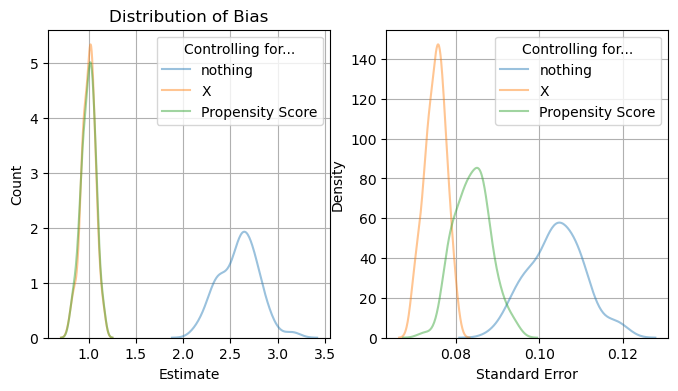

In [51]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))

ax3=sns.kdeplot(df_coef['naive'], alpha=0.45, label='nothing',ax=ax[0])
ax3=sns.kdeplot(df_coef['X'], alpha=0.45, label='X',ax=ax[0])
ax3=sns.kdeplot(df_coef['ps'], alpha=0.45, label='Propensity Score',ax=ax[0])
# ax3=sns.kdeplot(df_coef['X+ps'], alpha=0.45, label='Both',ax=ax[0])

ax3=sns.kdeplot(df_se['naive'], alpha=0.45, label='nothing',ax=ax[1])
ax3=sns.kdeplot(df_se['X'], alpha=0.45, label='X',ax=ax[1])
ax3=sns.kdeplot(df_se['ps'], alpha=0.45, label='Propensity Score',ax=ax[1])
# ax3=sns.kdeplot(df_se['X+ps'], alpha=0.45, label='Both',ax=ax[1])


ax[0].set_xlabel('Estimate')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Bias')
ax[0].legend(title='Controlling for...')
ax[0].grid()

ax[1].set_xlabel('Standard Error')
ax[1].legend(title='Controlling for...')
ax[1].grid()

plt.show()